# Transfer Learning With Tensorflow - Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning using feature extraction; now it's time to learn about a new kind of transfer learning: fine-tuning.

## Creating Helper Functions:

In previous notebooks, we've created a bunch of helper functions; now we could rewrite them all, however, this is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If you're running this notebook in Google Colab, when it times out, Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's Get Some Data:

This time, we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir, #image_dataset_from_directory is a faster, more efficient version of ImageDataGenerator and the flow_from_directory method combined
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = 'categorical',
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent #Notice that this creates an object of a new datatype (but it used to be of type BatchDataset in older versions)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1): #Notice that the object of the new datatype has many new methods, such as take, which unravels a number of batches
    print(images, labels)

tf.Tensor(
[[[[1.65943878e+02 1.71158157e+02 1.80357147e+02]
   [1.72285706e+02 1.76311234e+02 1.71096939e+02]
   [1.55984680e+02 1.56709183e+02 1.49913269e+02]
   ...
   [1.44438522e+02 1.47438522e+02 1.54009995e+02]
   [1.49673477e+02 1.53673477e+02 1.64698990e+02]
   [1.51831879e+02 1.55627808e+02 1.69260513e+02]]

  [[1.72066315e+02 1.68780609e+02 1.77132645e+02]
   [1.81448990e+02 1.81362259e+02 1.79642868e+02]
   [4.58928528e+01 4.80357094e+01 4.37500000e+01]
   ...
   [1.50209213e+02 1.54408173e+02 1.62923538e+02]
   [1.60561203e+02 1.64836746e+02 1.77122482e+02]
   [1.58479492e+02 1.64550919e+02 1.79408127e+02]]

  [[1.79617340e+02 1.72561234e+02 1.77561218e+02]
   [6.34846878e+01 6.15408096e+01 6.19438667e+01]
   [2.80255070e+01 3.26989746e+01 3.35306091e+01]
   ...
   [1.64076843e+02 1.69816620e+02 1.81173813e+02]
   [1.84811234e+02 1.91596954e+02 2.07311264e+02]
   [1.87862106e+02 1.94862106e+02 2.12867249e+02]]

  ...

  [[2.29137756e+02 2.31137756e+02 2.43137756e+02]
   [2

## Model 0 - Building A Transfer Learning Feature Extraction Model Using The Keras Functional API:

The sequential API is straight-forward; it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False) #The include_top parameter specifies whether or not to use the original output layer from the model you're importing

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input layer') #The first layer in a functional api tensorflow model is the input layer

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s), as it's built in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255) #A benefit of using functional apis is that you can insert normalization layers directly into your model

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x) #The general syntax of the intermediate layers is that you pass the output of one layer onto the end of another
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning', experiment_name = '10_percent_feature_extraction')])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250904-132152
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.2850 - loss: 2.1301 - val_accuracy: 0.7023 - val_loss: 1.3619
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7702 - loss: 1.1641 - val_accuracy: 0.8010 - val_loss: 0.8957
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.8201 - loss: 0.8252 - val_accuracy: 0.8405 - val_loss: 0.6983
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8573 - loss: 0.6595 - val_accuracy: 0.8322 - val_loss: 0.6352
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.9157 - loss: 0.5264 - val_accuracy: 0.8618 - val_loss: 0.5599


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.8539 - loss: 0.5655


[0.5648854970932007, 0.8551999926567078]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [13]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# How about a summary of our whole model?
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

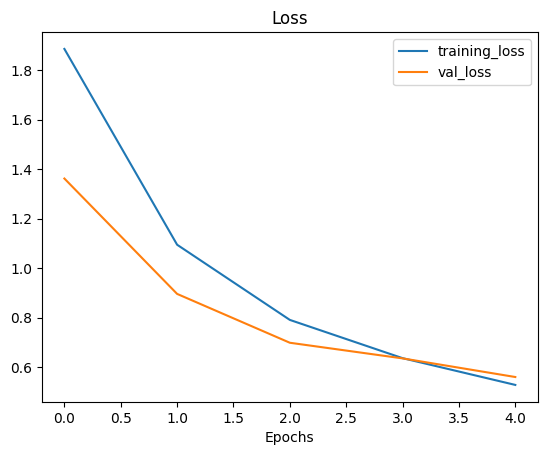

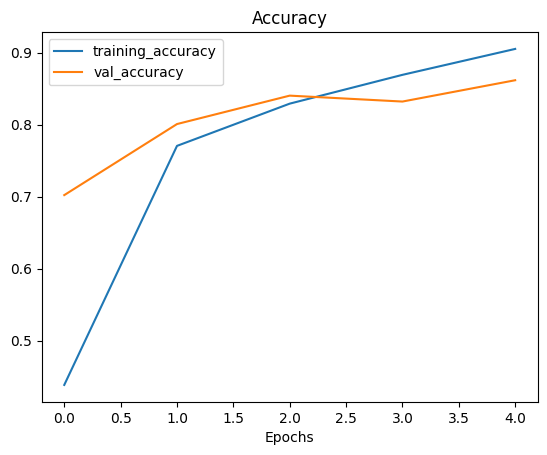

In [15]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

⚠️ **Update**: `tf.keras.applications.EfficientNetB0` (version 1) is outdated and is now known for producing errors in various versions of tensorflow. You should replace it with `tf.keras.applications.efficientnet_v2.EfficientNetV2B0` (version 2). Therefore, let's create another model with the update applied, and we'll call it model 0.5

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input layer') #The first layer in a functional api tensorflow model is the input layer

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s), as it's built in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255) #A benefit of using functional apis is that you can insert normalization layers directly into your model

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0_5 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0_5.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model and save its history
history_10_percent_2 = model_0_5.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning', experiment_name = '10_percent_feature_extraction_2')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction_2/20250910-191040
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.2212 - loss: 2.1471 - val_accuracy: 0.7237 - val_loss: 1.3138
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7362 - loss: 1.2370 - val_accuracy: 0.7895 - val_loss: 0.9023
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.8070 - loss: 0.8886 - val_accuracy: 0.8273 - val_loss: 0.7194
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.8431 - loss: 0.7249 - val_accuracy: 0.8421 - val_loss: 0.6374
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.8612 - loss: 0.6137 - val_accuracy: 0.8536 - val_loss: 0.5729


In [11]:
# Evaluate on the full test dataset again
model_0_5.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8668 - loss: 0.5469


[0.568215012550354, 0.8583999872207642]

In [12]:
# How about a summary of our new model?
model_0_5.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

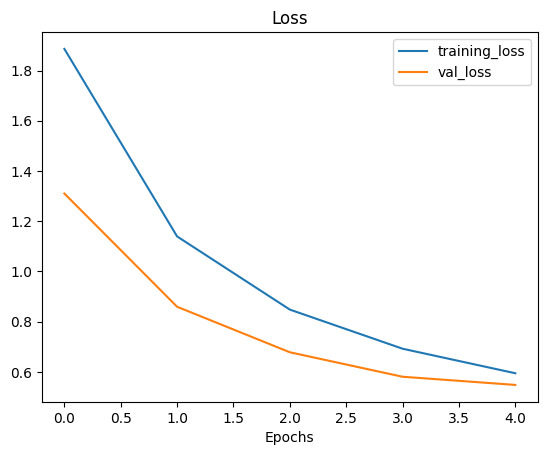

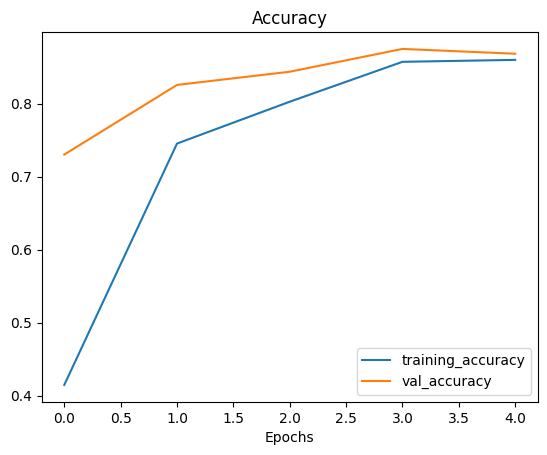

In [13]:
# Check out our model's training curves
plot_loss_curves(history_10_percent_2)

## Getting A Feature Vector From A Trained Model:

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [14]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [15]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

🛠️ **Practice:** Try to do the same with the above two cells, but this time, use `GlobalMaxPool2D`... and see what happens.

🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer), which can then be used to extract patterns out of it for our own specific problem.

## Running A Series Of Transfer Learning Experiments:

We've seen the incredible results transfer learning can et with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - Use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - Use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - Use fine-tuning transfer learning on 100% of the training data with data augmentation

🔑 **Note:** Throughout all experiments, the same test dataswt will be used to evaluate our model... this ensures consistence across evaluation metrics.

## Getting And Preprocessing Data For model_1:

In [16]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [3]:
# How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [7]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation Right Into The Model:

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster, if applicable) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

⚠️ **Update**: `tf.keras.layers.experimental.preprocessing()` is no longer experimental and has been fully implemented and moved to `tf.keras.layers`.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing #No longer experimental, and now implemented directly into tf.keras.layers

ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_agumentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'), #Replace 'preprocessing' with 'layers'
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1./255) # Keep for models like RseNet50V2, but EfficientNet's having rescaling built-in
], name = 'data_augmentation')

NameError: name 'preprocessing' is not defined

In [ ]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    layers.Input(shape = (224, 224, 3)), #You now have to explicitly specify the input shape of an entire model being passed into another model as well
    layers.RandomFlip('horizontal'), #You shouldn't flip food images vertically because nearly no one takes photos of food upside-down!
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    #layers.Rescale(1./255) # Keep for models like RseNet50V2, but EfficientNet's having rescaling built-in
], name = 'data_augmentation')

### Visualize Our Data Augmentation Layer (And See What Happens To Our Data):

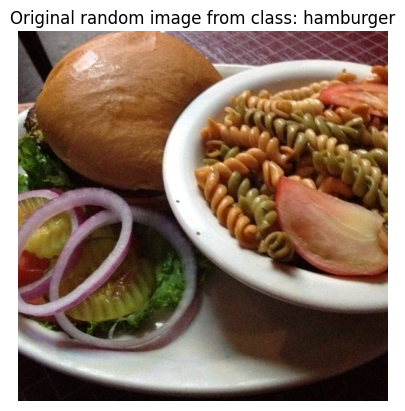

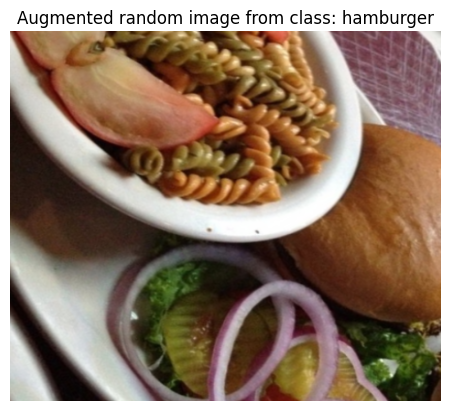

In [15]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class: {target_class}')
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False);

## Model 1 - Feature Extraction Transfer Learning On 1% Of The Data With Data Augmentation:

⚠️ **Update**: From this point forward, to be safe, we will be using the new version of the efficient net model for our base models.

In [16]:
# Setup imput shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs) #If you're passing in a whole model to a bigger model, it goes inside the original parentheses

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning', experiment_name = '1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250910-155219
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 133s 32s/step - accuracy: 0.0670 - loss: 2.4323 - val_accuracy: 0.1382 - val_loss: 2.2938
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 59s 27s/step - accuracy: 0.1807 - loss: 2.1897 - val_accuracy: 0.2072 - val_loss: 2.1697
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 19s/step - accuracy: 0.3544 - loss: 1.9397 - val_accuracy: 0.2730 - val_loss: 2.0850
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 19s/step - accuracy: 0.3725 - loss: 1.9038 - val_accuracy: 0.3470 - val_loss: 1.9875
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 18s/step - accuracy: 0.5435 - loss: 1.7481 - val_accuracy: 0.4112 - val_loss: 1.8784


In [17]:
# Check out a model summary
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug
#Despite having worse results than models 0/0.5, the results are actually quite similar to those from the best CNNs that were hand coded back in module 3.

79/79 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.3997 - loss: 1.8952


[1.8784626722335815, 0.4203999936580658]

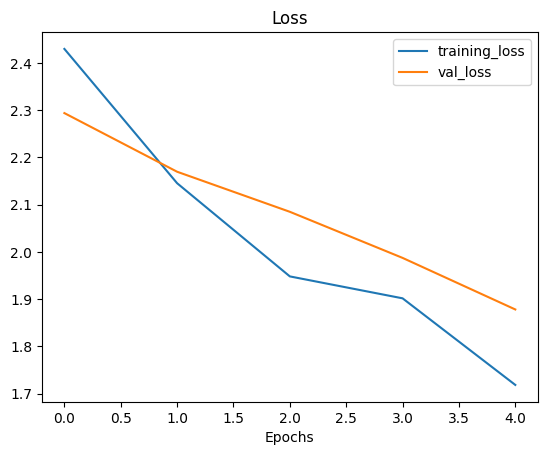

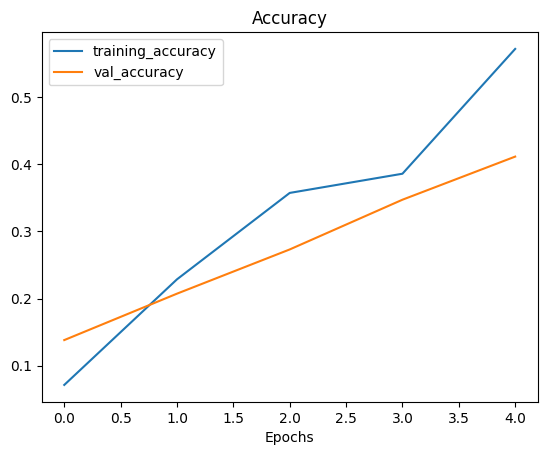

In [19]:
# How do the model with 1% of the data with data augmentation's loss curves look?
plot_loss_curves(history_1_percent)

## Model 2 - Feature Extraction Transfer Learning Model With 10% Of Data And Data Augmentation:

In [2]:
# Get 10% of data... (uncomment if you don't have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data('10_food_classes_10_percent.zip')

train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [3]:
# How many images are in our directories?
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = 'categorical',
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [24]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Build data augmentation layer
data_augmentation = Sequential([
    layers.Input(input_shape),
    layers.RandomFlip('horizontal'),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    #layers.Rescaling(1./255) # If you're using a model such as ResNet50V2, you'll need to rescalte your data, efficientnet has rescaling built-in.
], name = 'data_augmentation')

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = data_augmentation(inputs) # Augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training = False) # Pass augmented images to base model but keep it in inference mode; this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [6]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2D       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Creating A ModelCheckpoint Callback:

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come back and start where we left off.

In [7]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints/weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True, #The save_weights_only parameter selects whether to save only the training model's weights or the entire model every epoch
                                                         save_best_only = False, #The save_best_only parameter monitors (by default) the model's validation loss and only save the model or weights with the lowest validation loss, regardless of which epoch it was on
                                                         save_freq = 'epoch', # Save every epoch
                                                         verbose = 1)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=ten_percent_model_checkpoints/weights/checkpoint.ckpt

In [25]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints/weights/checkpoint.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = 'epoch',
                                                         verbose = 1)

### Fit Model 2, Passing In The ModelCheckpoint Callback:

In [26]:
# Fit the model, saving checkpoints every epoch
initial_epochs = 5 #We'll see the power of this variable in the next model
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                   experiment_name = '10_percent_data_aug'),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250916-100403
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2335 - loss: 2.1514
Epoch 1: saving model to ten_percent_model_checkpoints/weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.2378 - loss: 2.1448 - val_accuracy: 0.6151 - val_loss: 1.5200
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5661 - loss: 1.5313
Epoch 2: saving model to ten_percent_model_checkpoints/weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.5686 - loss: 1.5266 - val_accuracy: 0.7303 - val_loss: 1.1026
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7128 - loss: 1.1894
Epoch 3: saving model to ten_percent_model_checkpoints/weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.7131 - loss: 1.1875 - val_accuracy: 0.7747 - val_loss: 0.9065
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.74

In [12]:
# What were model_0.5's results?
model_0_5.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8649 - loss: 0.5473


[0.5686862468719482, 0.8543999791145325]

In [27]:
# Check model_2's results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8118 - loss: 0.6920


[0.6859799027442932, 0.8112000226974487]

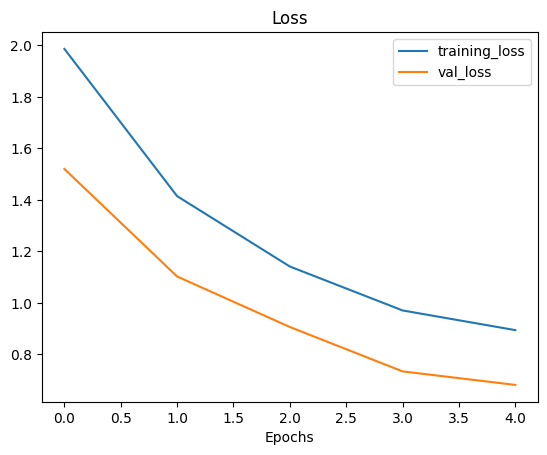

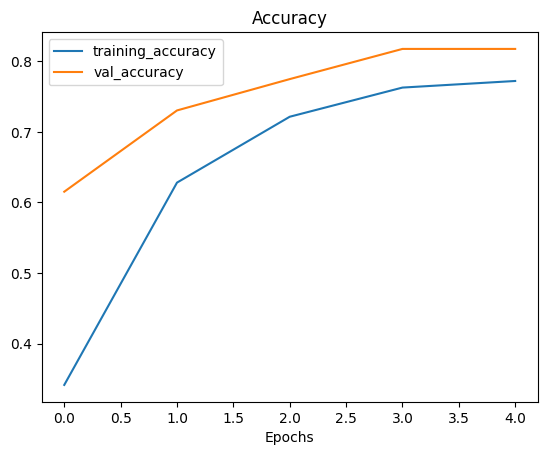

In [28]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading In Checkpointed Weights:

Loading in checkpointed weights returns a model to a specific checkpoint.

In [29]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [30]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8135 - loss: 0.6892


In [31]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results #Sometimes this will display false, but the numbers are still close due to how computers store numbers

False

In [32]:
results_10_percent_data_aug

[0.6859799027442932, 0.8112000226974487]

In [33]:
loaded_weights_model_results

[0.6859797239303589, 0.8112000226974487]

In [34]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [35]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.78813934e-07 0.00000000e+00]


# Model 3 - Fine-Tuning An Existing Model On 10% Of The Data:

🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [9]:
# Layers in loaded model
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_2D, built=True>,
 <Dense name=output_layer, built=True>]

In [10]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_2D, built=True> True
<Dense name=output_layer, built=True> True


In [ ]:
# What layers are in our base_model (EfficientNetV2B0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_layer_3 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [12]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [47]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # When fine-tuning, you typically want to lower the learning rate by 10x*
                metrics = ['accuracy'])

🔑 **Note:** When using fine-tuning, it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [21]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [22]:
# Now that we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [23]:
model_2.trainable_variables

[<Variable path=block6h_se_reduce/kernel, shape=(1, 1, 1152, 48), dtype=float32, value=[[[[-0.00207604  0.01300672  0.02047416 ... -0.02240255 -0.07708141
     -0.00094655]
    [-0.06357138  0.0959678  -0.05430871 ... -0.01352078 -0.05987524
     -0.11093444]
    [ 0.0068749  -0.04681807 -0.01513974 ...  0.03073284 -0.01280731
      0.03616464]
    ...
    [ 0.11381665  0.00804447 -0.05432149 ...  0.08015257 -0.06561387
     -0.05522665]
    [-0.12468243  0.06938899 -0.07634895 ...  0.01121222 -0.0128268
      0.10406019]
    [-0.04722364  0.10557885  0.16247186 ...  0.04582691  0.01228108
     -0.04941604]]]]>,
 <Variable path=block6h_se_reduce/bias, shape=(48,), dtype=float32, value=[ 0.04594925  2.5461788  -1.426646   -0.7885664  -0.24730209 -0.5630991
  -0.6161863  -0.4029834  -1.4444699  -1.0481553  -0.21704195 -0.64428073
  -1.0262699   0.51246476 -1.1002927  -0.57510656 -0.4755902   0.78507984
  -0.21726058 -0.8636311  -0.5850221  -0.6715491  -0.8322267   0.26295963
  -1.1431009

In [48]:
# Fine turn for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                               callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                        experiment_name = '10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250916-102954
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.7770 - loss: 1.0129 - val_accuracy: 0.8174 - val_loss: 0.7362
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8119 - loss: 0.8758 - val_accuracy: 0.8273 - val_loss: 0.6650
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7817 - loss: 0.8532 - val_accuracy: 0.8306 - val_loss: 0.6076
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.7926 - loss: 0.7851 - val_accuracy: 0.8487 - val_loss: 0.5515
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8180 - loss: 0.7573 - val_accuracy: 0.8372 - val_loss: 0.5541
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.8294 - loss: 0.6719 - val_accuracy: 0.8421 - val_loss: 0.5326


In [53]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8462 - loss: 0.5275


In [52]:
results_10_percent_data_aug

[0.6859799027442932, 0.8112000226974487]

🎉 **Bonus**: You can now save model training histories for later use so that you don't have to retrain the model just to get the history back! Just save the model's history with numpy and then use pickle loading to load the history back in. Here's a demo:

In [ ]:
import numpy as np
np.save('history_10_percent_data_aug.npy', history_10_percent_data_aug)

In [57]:
history_10_percent_data_aug = np.load('history_10_percent_data_aug.npy', allow_pickle = True).item()

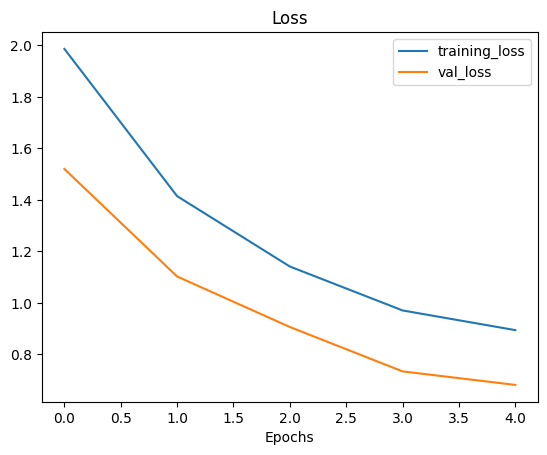

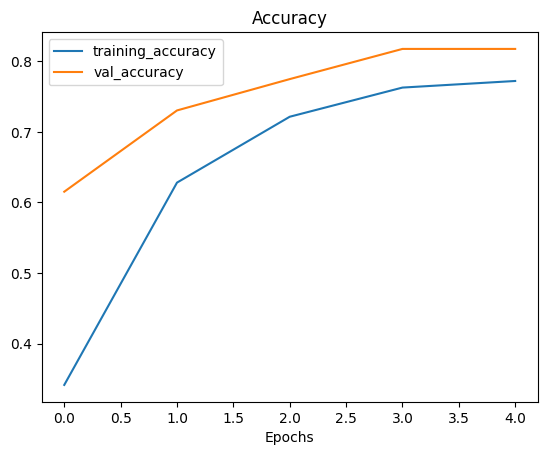

In [58]:
plot_loss_curves(history_10_percent_data_aug)

In [49]:
np.save('history_fine_10_percent_data_aug.npy', history_fine_10_percent_data_aug)

In [51]:
history_fine_10_percent_data_aug = np.load('history_fine_10_percent_data_aug.npy', allow_pickle = True).item()

In [55]:
#Also save model_2
model_2.save('fine_tune_10_percent.keras')

In [56]:
model_2 = tf.keras.models.load_model('fine_tune_10_percent.keras')

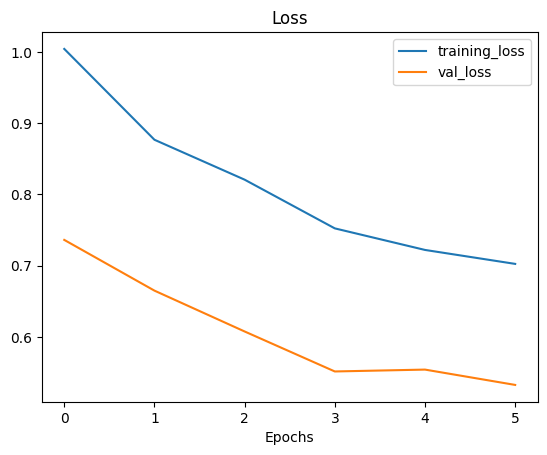

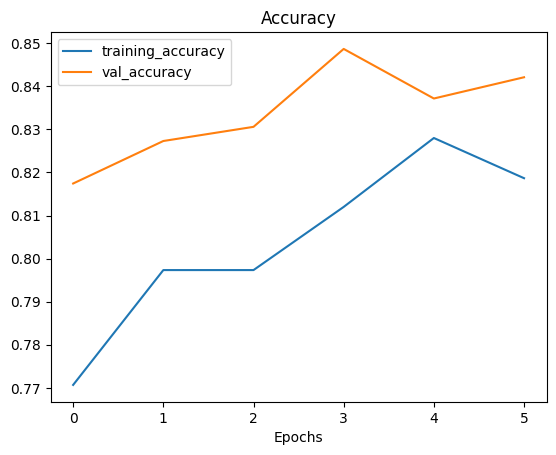

In [54]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [66]:
# Let's create a function to compare training histories
import matplotlib.pyplot as plt
def compare_histories(original_history, new_history, initial_epochs = 5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine original_history metrics with new_history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Make plot for accuracy
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label = 'Training Accuracy')
    plt.plot(total_val_acc, label = 'Val Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'Start Fine Tuning')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    # Make plot for loss
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label = 'Training Loss')
    plt.plot(total_val_loss, label = 'Val Loss')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'Start Fine Tuning')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')

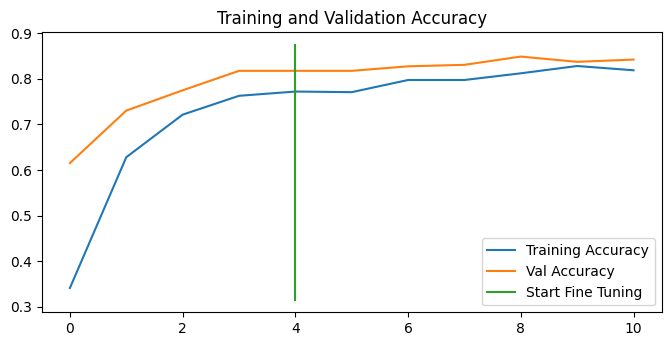

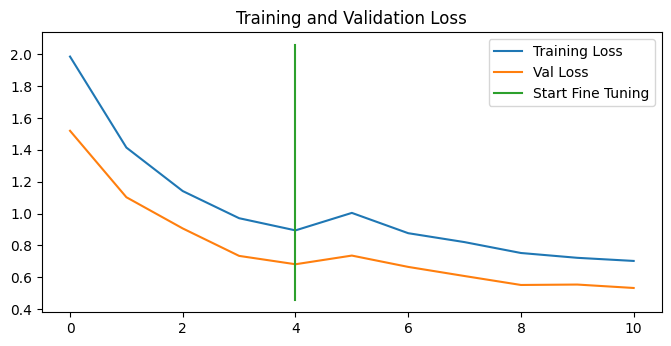

In [67]:
compare_histories(history_10_percent_data_aug, history_fine_10_percent_data_aug, initial_epochs = 5)

## Model 4 - Fine-Tuning An Existing Model On All Of The Data:

In [68]:
# Dowload and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [72]:
# Set up training and test dir
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [70]:
# How many images are we working with now?
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [73]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = 'categorical',
                                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [74]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.8508 - loss: 0.5107


[0.5149884819984436, 0.8532000184059143]

In [75]:
results_fine_tune_10_percent

[0.514988362789154, 0.8532000184059143]

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature_extraction weights.

In [76]:
# Load weights from checkpoint, that we we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

c:\Users\Jake\Documents\Udemy Courses\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [77]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.8125 - loss: 0.6763


[0.6859797239303589, 0.8112000226974487]

In [78]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6859799027442932, 0.8112000226974487]

Alright, the previous steps might seem quite confusing, but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using a `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2, except this time, we're going to use all of the data (model_4).

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)
    #Notice that the base model remained trainable despite reloading the weights

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetv2b0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)
    #If any sublayer within a larger model's layers are trainable, the whole layer in the big model will appear as trainable

0 input_layer_3 True
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwc

In [81]:
# Compile
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

In [82]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(-.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                    experiment_name = 'full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20250916-143301
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - accuracy: 0.7259 - loss: 0.9982 - val_accuracy: 0.8760 - val_loss: 0.4223
Epoch 6/10


c:\Users\Jake\Documents\Udemy Courses\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


235/235 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step - accuracy: 0.7827 - loss: 0.7370 - val_accuracy: 0.8936 - val_loss: 0.3490
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 606s 3s/step - accuracy: 0.8014 - loss: 0.6422 - val_accuracy: 0.9004 - val_loss: 0.3056
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.8289 - loss: 0.5779 - val_accuracy: 0.9072 - val_loss: 0.2848
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - accuracy: 0.8291 - loss: 0.5526 - val_accuracy: 0.9096 - val_loss: 0.2723
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - accuracy: 0.8407 - loss: 0.5216 - val_accuracy: 0.9200 - val_loss: 0.2563


In [83]:
#Save model_2 and its history
import numpy as np
model_2.save('fine_tune_full.keras')
np.save('history_fine_10_classes_full.npy', history_fine_10_classes_full)

In [84]:
#Load model_2 and its history
model_2 = tf.keras.models.load_model('fine_tune_full.keras')
history_fine_10_classes_full = np.load('history_fine_10_classes_full.npy', allow_pickle = True).item()

In [86]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.9207 - loss: 0.2629


[0.2563171684741974, 0.9200000166893005]

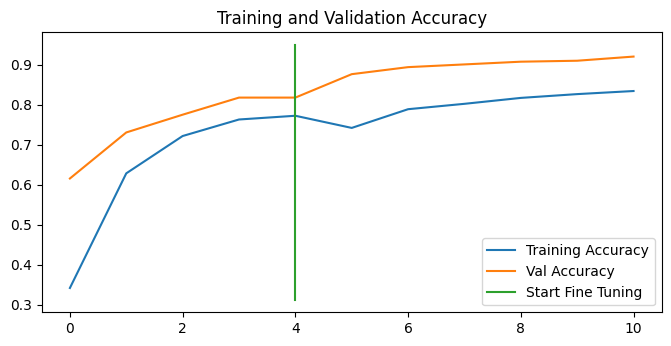

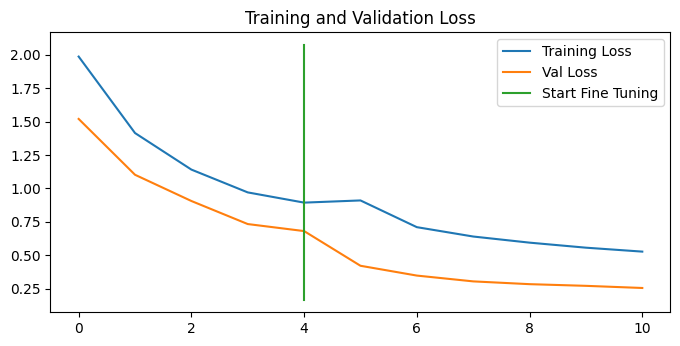

In [87]:
# How did fine-tuning go with more data?
compare_histories(original_history = history_10_percent_data_aug, new_history = history_fine_10_classes_full, initial_epochs = 5)

## Viewing Our Experiment Data On TensorBoard:

🔑 **Note:** Anything you upload to ATensorBoard.dev is going to be public. So if you have private data, do not upload.

In [88]:
# View tensorboard logs of transfer learning modelling experiment (should be ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
    --one_shot # exits the uploader once it's finished uploading

2025-09-17 10:40:38.184411: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 10:40:50.887113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


⚠️ Come back after you finish this course to find a replacement to TensorBoard.dev!

In [ ]:
# View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

2025-09-17 10:48:14.454526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 10:48:22.557177: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [90]:
# To delete an experiment
!tensorboard dev delete --experiment_id (insert id here)

2025-09-17 10:49:40.997518: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 10:49:44.139144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.
